In [2]:
import pandas as pd
import random
# import seaborn as sns
import numpy as np
import tensorflow as tf
import tensorflow_privacy as tfp
import tensorflow_federated as tff
from sklearn.preprocessing import LabelEncoder , StandardScaler

import matplotlib.pyplot as plt
import logging
import warnings

# Filter out the specified warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in divide", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in subtract", category=RuntimeWarning)
# Set the logging level to suppress DeprecationWarnings
logging.captureWarnings(True)
logging.getLogger("absl").setLevel(logging.ERROR)

2024-03-21 10:38:50.516896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 10:38:50.547705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 10:38:50.547731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 10:38:50.547754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 10:38:50.553114: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 10:38:50.553587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
dataset =pd.read_csv("/home/mirwais/Desktop/datasets in desktop/Opinion data.csv")
features = list(dataset.drop(['user_id','x4','m8'], axis=1).columns)
dataset.head()

,user_id,m8,x34a,z14,x5a,x5b,x6a,x6b,x26a,x11ad,x11af,x34d,x4
0,Central,2006,A fair a,3,women ha,refugees,Null,Null,some fea,yes,no,not very,Right
1,Central,2006,A fair a,2,Null,Null,there is,no recon,some fea,yes,yes,not very,Wrong
2,Central,2006,Not very,3,reconstr,women ha,Null,Null,some fea,yes,no,no trust,Right
3,Central,2006,Not very,3,Null,Null,no recon,there is,no fear,yes,no,not very,Wrong
4,Central,2006,Not very,4,Null,Null,no recon,there is,some fea,yes,no,a fair a,Wrong


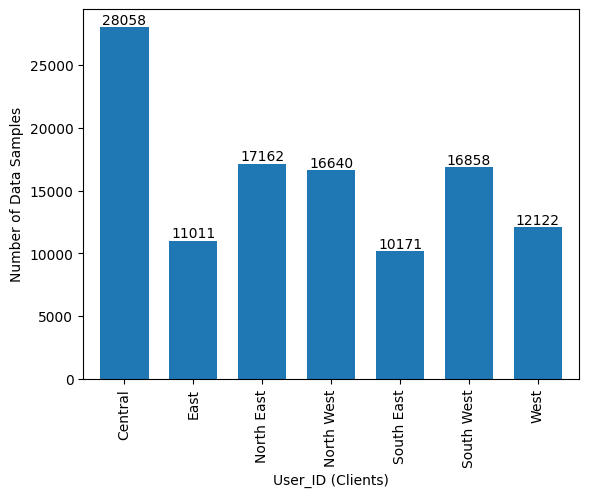

In [3]:
user_counts = dataset.groupby('user_id').size()
user_counts.plot(kind='bar', width=0.7)  # Adjust the width parameter as needed

# Add values on top of each bar with a bit of space
for i, count in enumerate(user_counts):
    plt.text(i, count + 0.1, f'{count}', ha='center', va='bottom')

# Customize axis labels
plt.xlabel('User_ID (Clients)')
plt.ylabel('Number of Data Samples')

# Save the plot to a PDF file
plt.savefig('/home/mirwais/Downloads/Survey_data_distribution.pdf', bbox_inches='tight')
plt.show()

In [3]:
# Encode categorical variables
label_encoder = LabelEncoder()
for column in dataset.select_dtypes(include=["object"]).columns:
    dataset[column] = label_encoder.fit_transform(dataset[column])

In [4]:
dataset.head()

,user_id,m8,x34a,z14,x5a,x5b,x6a,x6b,x26a,x11ad,x11af,x34d,x4
0,0,2006,0,3,74,62,1,1,5,3,1,5,0
1,0,2006,0,2,0,0,72,49,5,3,3,5,1
2,0,2006,5,3,61,73,1,1,5,3,1,4,0
3,0,2006,5,3,0,0,50,71,3,3,1,5,1
4,0,2006,5,4,0,0,50,71,5,3,1,1,1


In [5]:
NUM_EPOCHS = 30
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10
ROUNDS =30

features = list(dataset.drop(['user_id','x4','m8'], axis=1).columns)
input_shape = len(features)
client_ids = dataset['user_id'].unique()
num_clients = len(client_ids)

In [6]:
#@title utilities
def custom_train_test_split(df, split_percentage=0.7):
    split_size = int(len(df) * split_percentage)
    indices = list(range(len(df)))
    random.shuffle(indices)

    # Split the indices into two parts
    train_indices = indices[:split_size]
    test_indices = indices[split_size:]

    # Create training and testing DataFrames
    df_train = df.iloc[train_indices]
    df_test = df.iloc[test_indices]

    return df_train, df_test

def create_client_datasets(dataset):
    dataset_copy = dataset.copy()
    grouped = dataset_copy.groupby('user_id')
    client_data_dict = {}

    for client_id, group in grouped:
        datasets = tf.data.Dataset.from_tensor_slices((group[features], group.pop('x4'))).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)

        client_data_dict[client_id] = datasets

    # Create a client data object
    client_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=list(client_data_dict.keys()),
        serializable_dataset_fn=lambda client_id: client_data_dict[client_id]
    )

    return client_data

def preprocess(client_dataset,features):
    dataset_copy = client_dataset.copy()
    tf_dataset = tf.data.Dataset.from_tensor_slices((dataset_copy[features], dataset_copy.pop('x4'))).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)
    return tf_dataset


def make_federated_data(dataset,client_ids):
    client_data = create_client_datasets(dataset)
    return [client_data.create_tf_dataset_for_client(x) for x in client_ids]

In [7]:
normal_dataset, shadow_dataset = custom_train_test_split(dataset, split_percentage=0.5)
df_train, df_test = custom_train_test_split(normal_dataset, split_percentage=0.7)
shadow_df_train, shadow_df_test = custom_train_test_split(shadow_dataset, split_percentage=0.7)

In [8]:
federated_data = make_federated_data(df_train, client_ids)
print(f'Number of client datasets: {len(federated_data)}')
print(f'First dataset: {federated_data[0]}')

Number of client datasets: 7
First dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [9]:
#@title Add F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.round(y_pred), tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_shape,), name='input_layer'),
        tf.keras.layers.Dense(60, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')
    ])

def model_fn():
    keras_model = create_keras_model()
    tff_metrics = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve="pr"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        F1Score()
    ]

    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=federated_data[0].element_spec,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=tff_metrics
    )

In [10]:
#@title Normal Federated Functions

@tff.tf_computation
def server_init():
    model = model_fn()
    return model.trainable_variables

@tf.function
def client_update(model, dataset, server_weights, client_optimizer):
    client_weights = model.trainable_variables
    tf.nest.map_structure(lambda x, y: x.assign(y), client_weights, server_weights)

    for batch in dataset:
        with tf.GradientTape() as tape:
            outputs = model.forward_pass(batch)

        grads = tape.gradient(outputs.loss, client_weights)
        grads_and_vars = zip(grads, client_weights)
        client_optimizer.apply_gradients(grads_and_vars)

    return client_weights

whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)
model_weights_type = server_init.type_signature.result
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)
metrics = [tf.keras.metrics.BinaryAccuracy(), F1Score()]

@tf.function
def server_update(model, mean_client_weights):
    model_weights = model.trainable_variables
    tf.nest.map_structure(lambda x, y: x.assign(y), model_weights, mean_client_weights)
    return model_weights

@tff.federated_computation
def initialize_fn():
    return tff.federated_value(server_init(), tff.SERVER)

@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
    model = model_fn()
    client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    return client_update(model, tf_dataset, server_weights, client_optimizer)

@tff.tf_computation(model_weights_type)
def server_update_fn(mean_client_weights):
    model = model_fn()
    return server_update(model, mean_client_weights)

@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
    server_weights_at_client = tff.federated_broadcast(server_weights)
    client_weights = tff.federated_map(client_update_fn, (federated_dataset, server_weights_at_client))
    mean_client_weights = tff.federated_mean(client_weights)
    server_weights = tff.federated_map(server_update_fn, mean_client_weights)
    return server_weights, client_weights

def evaluate(server_state):
    keras_model = create_keras_model()
    keras_model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    keras_model.set_weights(server_state)
    test_df = preprocess(df_test, features)
    return keras_model.evaluate(test_df, verbose=0)

In [11]:
#@title Federated Training
normal_federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)
server_state = normal_federated_algorithm.initialize()

clients = {}
history = []

for round in range(ROUNDS):
    server_state , client_weights = normal_federated_algorithm.next(server_state, federated_data)
    clients[round] = client_weights
    loss, accuracy , f1_score_value  = evaluate(server_state)
    history.append([loss, accuracy, f1_score_value])
    print(f'Round: {round}')
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1_score_value:.4f}")
    print('.'*70)

2024-02-26 16:45:54.222083: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 16:45:54.222184: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-26 16:45:56.457311: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 16:45:56.457434: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-26 16:45:56.553034: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 16:45:56.553096: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-26 16:45:56.557991: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 16:45:56.558042: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Round: 0

Test Loss: 0.0637
Test Accuracy: 0.9660
Test F1 Score: 0.9605
......................................................................
Round: 1

Test Loss: 0.0583
Test Accuracy: 0.9677
Test F1 Score: 0.9621
......................................................................
Round: 2

Test Loss: 0.0568
Test Accuracy: 0.9683
Test F1 Score: 0.9628
......................................................................
Round: 3

Test Loss: 0.0563
Test Accuracy: 0.9686
Test F1 Score: 0.9631
......................................................................
Round: 4

Test Loss: 0.0561
Test Accuracy: 0.9688
Test F1 Score: 0.9634
......................................................................
Round: 5

Test Loss: 0.0561
Test Accuracy: 0.9689
Test F1 Score: 0.9634
......................................................................
Round: 6

Test Loss: 0.0560
Test Accuracy: 0.9689
Test F1 Score: 0.9635
......................................................................

In [12]:
normal_client_weights = clients[list(clients)[-1]]

In [13]:
#@title Noisy Federated Functions

# Define the L2 norm clip
L2_norm_clip = 0.1
float_type = tff.TensorType(dtype=tf.float32)

@tf.function
def noisy_client_update(model, dataset, server_weights, client_optimizer, noise_multiplier):
    client_weights = model.trainable_variables
    tf.nest.map_structure(lambda x, y: x.assign(y), client_weights, server_weights)

    for batch in dataset:
        # Add Gaussian noise to the input batch
        noisy_batch = (
            tf.cast(batch[0], tf.float32) + tf.random.normal(shape=tf.shape(batch[0]), stddev=noise_multiplier),
            tf.cast(batch[1], tf.float32) + tf.random.normal(shape=tf.shape(batch[1]), stddev=noise_multiplier)
        )

        with tf.GradientTape() as tape:
            outputs = model.forward_pass(noisy_batch)

        grads = tape.gradient(outputs.loss, client_weights)

        # Clip gradients
        clipped_gradients = [tf.clip_by_norm(g, L2_norm_clip) for g in grads]

        # Add Gaussian noise
        noisy_gradients = [g + tf.random.normal(shape=tf.shape(g), stddev=L2_norm_clip * noise_multiplier)
                           for g in clipped_gradients]

        # Apply the gradient using a client optimizer.
        client_optimizer.apply_gradients(zip(noisy_gradients, client_weights))

    return client_weights

@tf.function
def noisy_server_update(model, mean_client_weights):
    model_weights = model.trainable_variables
    tf.nest.map_structure(lambda x, y: x.assign(y), model_weights, mean_client_weights)
    return model_weights

@tff.tf_computation(tf_dataset_type, model_weights_type, float_type)
def noisy_client_update_fn(tf_dataset, server_weights, noise_multiplier):
    model = model_fn()
    client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    return noisy_client_update(model, tf_dataset, server_weights, client_optimizer, noise_multiplier)

@tff.tf_computation(model_weights_type)
def noisy_server_update_fn(mean_client_weights):
    model = model_fn()
    return noisy_server_update(model, mean_client_weights)

@tff.tf_computation
def noisy_server_init():
    model = model_fn()
    return model.trainable_variables

@tff.federated_computation
def noisy_initialize_fn():
    return tff.federated_value(server_init(), tff.SERVER)

@tff.federated_computation(federated_server_type, federated_dataset_type, float_type)
def noisy_next_fn(server_weights, federated_dataset, noise_multiplier):
    # Broadcast the server weights to the clients.
    server_weights_at_client = tff.federated_broadcast(server_weights)
    noise_federated = tff.federated_value(noise_multiplier, tff.CLIENTS)

    # Each client computes their updated weights.
    client_weights = tff.federated_map(noisy_client_update_fn, (federated_dataset, server_weights_at_client, noise_federated))

    # The server averages these updates.
    mean_client_weights = tff.federated_mean(client_weights)

    # The server updates its model.
    server_weights = tff.federated_map(noisy_server_update_fn, mean_client_weights)
    return server_weights, client_weights

def run_noisy_federated_algorithm(noise, federated_data, ROUNDS):
    # Define the noisy_federated_algorithm
    noisy_federated_algorithm = tff.templates.IterativeProcess(
        initialize_fn=noisy_initialize_fn,
        next_fn=noisy_next_fn
    )

    # Reset the server state for each noise value
    server_state = noisy_federated_algorithm.initialize()

    # Evaluate initial server state
    loss, accuracy, f1_score_value = evaluate(server_state)
    print(f"Initial Loss: {loss}, Accuracy: {accuracy}, F1 Score: {f1_score_value}")
    print('-' * 70)

    clients = {}
    history = []

    for round in range(ROUNDS):
        # Update the server state with the next iteration
        noise_list = [noise for _ in range(num_clients)]
        # noise_federated = tff.federated_value(noise_list, tff.CLIENTS)
        res = noisy_federated_algorithm.next(server_state, federated_data, noise)
        server_state, client_weights = res
        clients[round] = client_weights

        # Evaluate the performance after each round
        loss, accuracy, f1_score_value = evaluate(server_state)
        history.append([loss, accuracy, f1_score_value])

        print(f'Round: {round}')
        print(f"\nTest Loss: {loss:.4f}")
        print(f"Test Accuracy: {accuracy :.4f}")
        print(f"Test F1 Score: {f1_score_value:.4f}")
        print(f"Noise Value: {noise}")
        print('.' * 70)

    return clients, server_state, history

In [14]:
# List of noise values to test
step_size =2
noise_values = np.arange(2, 11, step_size).tolist()

# noise_values = [0.5, 0.9, 1.5, 2.7, 3.9]
N_history_per_noise = {}
noisy_clients_weights = {}
noisy_server_weights = {}
for noise_value in noise_values:
    clients, final_server_state, history = run_noisy_federated_algorithm(noise_value,federated_data,ROUNDS)
    N_history_per_noise[noise_value] = history
    noisy_clients_weights[noise_value] = clients
    noisy_server_weights[noise_value] = final_server_state

2024-02-26 17:02:13.827184: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 17:02:13.827284: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Initial Loss: 5.631623268127441, Accuracy: 0.9510024785995483, F1 Score: 0.9437738060951233
----------------------------------------------------------------------


2024-02-26 17:02:31.423079: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 17:02:31.423191: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-26 17:02:31.520696: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 17:02:31.520753: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-26 17:02:31.525941: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 17:02:31.525984: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-26 17:02:31.531980: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-26 17:02:31.532032: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


Round: 0

Test Loss: 0.3898
Test Accuracy: 0.9485
Test F1 Score: 0.9411
Noise Value: 2
......................................................................
Round: 1

Test Loss: 0.2595
Test Accuracy: 0.9482
Test F1 Score: 0.9408
Noise Value: 2
......................................................................
Round: 2

Test Loss: 0.2250
Test Accuracy: 0.9486
Test F1 Score: 0.9413
Noise Value: 2
......................................................................
Round: 3

Test Loss: 0.1959
Test Accuracy: 0.9489
Test F1 Score: 0.9417
Noise Value: 2
......................................................................
Round: 4

Test Loss: 0.1732
Test Accuracy: 0.9495
Test F1 Score: 0.9420
Noise Value: 2
......................................................................
Round: 5

Test Loss: 0.1670
Test Accuracy: 0.9499
Test F1 Score: 0.9421
Noise Value: 2
......................................................................
Round: 6

Test Loss: 0.1560
Test Accuracy: 0.9503
Te

In [15]:
import tensorflow_privacy as tfp

results_per_noise = {}
delta = 1e-5

for round_num in range(ROUNDS):
    print(f"\nRound: {round_num + 1}")
    
    for noise_multiplier in noise_values:
        print(f"Noise Multiplier: {noise_multiplier}")
        
        n_client_epsilons = []
        n_client_renyi = []

        for i, dataset in enumerate(federated_data):
            epsilon, rdp = tfp.compute_dp_sgd_privacy(
                dataset.__len__().numpy(),
                BATCH_SIZE,
                noise_multiplier,
                round_num + 1,
                1e-2,
            )
            n_client_epsilons.append(epsilon)
            n_client_renyi.append(rdp)

        avg_epsilon = sum(n_client_epsilons) / len(n_client_epsilons)
        avg_rdp = sum(n_client_renyi) / len(n_client_renyi)

        print(f"    Average Epsilon = {avg_epsilon}, Average RDP = {avg_rdp}")

        results_per_noise[(noise_multiplier, round_num)] = {
            'avg_epsilon': avg_epsilon,
            'avg_rdp': avg_rdp
        }

# Debugging prints
for key, value in results_per_noise.items():
    print(f"\nNoise Multiplier: {key[0]}, Round: {key[1]}")
    print(f"    Average Epsilon = {value['avg_epsilon']}, Average RDP = {value['avg_rdp']}")



Round: 1
Noise Multiplier: 2
    Average Epsilon = 0.012974912276433806, Average RDP = 45.285714285714285
Noise Multiplier: 4
    Average Epsilon = 0.0, Average RDP = 62.857142857142854
Noise Multiplier: 6
    Average Epsilon = 0.0, Average RDP = 63.0
Noise Multiplier: 8
    Average Epsilon = 0.0, Average RDP = 100.14285714285714
Noise Multiplier: 10
    Average Epsilon = 0.0, Average RDP = 118.71428571428571

Round: 2
Noise Multiplier: 2
    Average Epsilon = 0.028370090264837448, Average RDP = 37.285714285714285
Noise Multiplier: 4
    Average Epsilon = 0.002453730801745435, Average RDP = 57.714285714285715
Noise Multiplier: 6
    Average Epsilon = 0.0, Average RDP = 63.0
Noise Multiplier: 8
    Average Epsilon = 0.0, Average RDP = 63.0
Noise Multiplier: 10
    Average Epsilon = 0.0, Average RDP = 72.28571428571429

Round: 3
Noise Multiplier: 2
    Average Epsilon = 0.04132497705250295, Average RDP = 32.714285714285715
Noise Multiplier: 4
    Average Epsilon = 0.00665142319084745, A

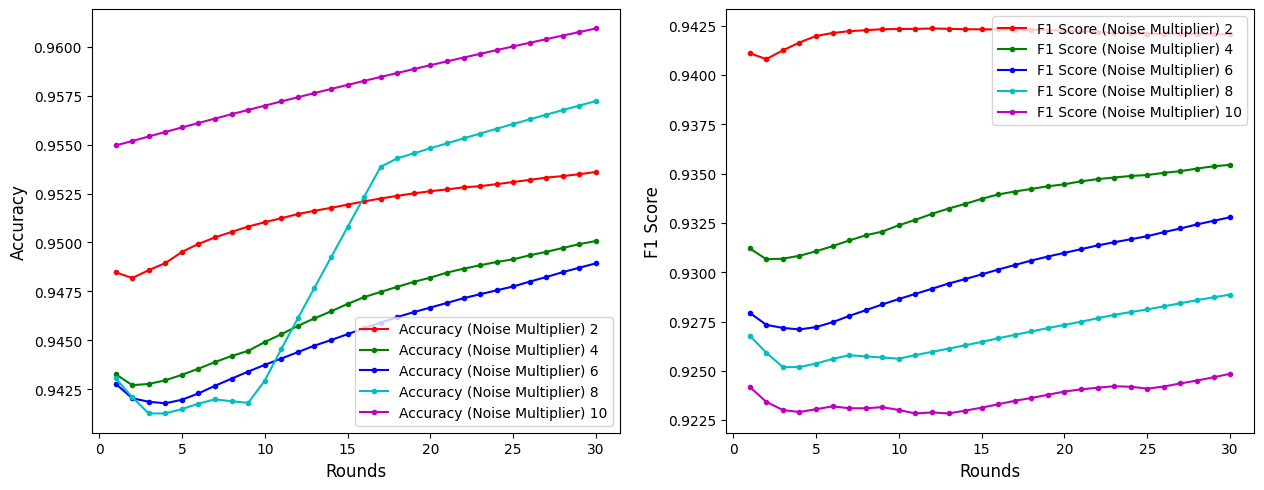

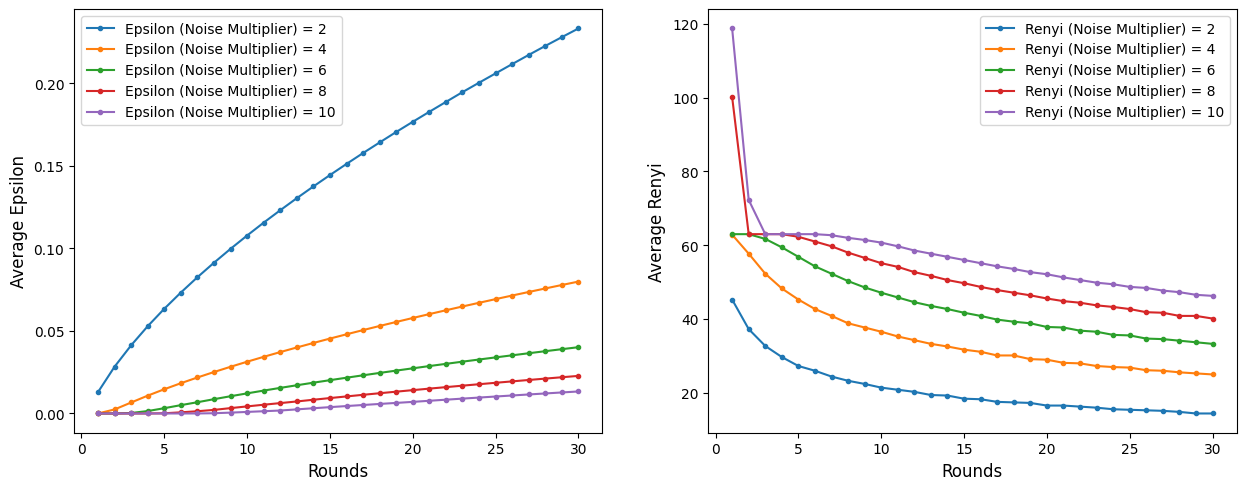

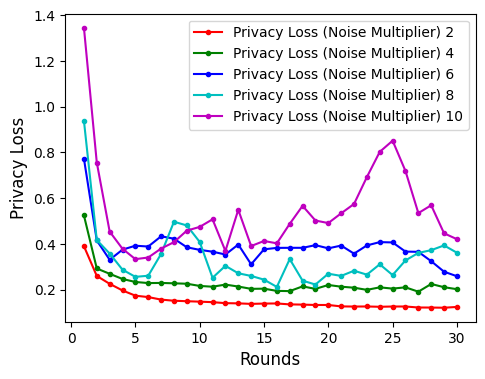

In [16]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Plotting parameters
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', '#FFA07A', '#8A2BE2', '#00FF7F']
labels = [f'Noise Multiplier {nm}' for nm in noise_values]

# Define font size
label_fontsize = 12
legend_fontsize = 10
title_fontsize = 14
axis_fontsize = 12

# Row 1: Accuracy and F1 Score
plt.figure(figsize=(15, 5.5))

# Plot Test Accuracy
plt.subplot(1, 2, 1)
for i, noise_multiplier in enumerate(noise_values):
    plt.plot(range(1, ROUNDS + 1), [entry[1] for entry in N_history_per_noise[noise_multiplier]], label=f'Accuracy (Noise Multiplier) {noise_multiplier}', color=colors[i], marker='.')
    plt.xlabel('Rounds', fontsize=axis_fontsize)
    plt.ylabel('Accuracy', fontsize=axis_fontsize)
    plt.legend(fontsize=legend_fontsize)

# Plot Test F1 Score
plt.subplot(1, 2, 2)
for i, noise_multiplier in enumerate(noise_values):
    plt.plot(range(1, ROUNDS + 1), [entry[2] for entry in N_history_per_noise[noise_multiplier]], label=f'F1 Score (Noise Multiplier) {noise_multiplier}', color=colors[i], marker='.')
    plt.xlabel('Rounds', fontsize=axis_fontsize)
    plt.ylabel('F1 Score', fontsize=axis_fontsize)
    plt.legend(fontsize=legend_fontsize)

# Save Accuracy and F1 Score plot to PDF
with PdfPages('/home/mirwais/Downloads/accuracy_f1_score.pdf') as pdf:
    pdf.savefig(bbox_inches='tight')

# Row 2: Privacy Loss, Epsilon, and Renyi Values
plt.figure(figsize=(15, 5.5))


# Plot Epsilon
plt.subplot(1, 2, 1)
for noise_multiplier in noise_values:
    plt.plot(range(1, ROUNDS + 1), [results_per_noise[(noise_multiplier, round)]['avg_epsilon'] for round in range(ROUNDS)], label=f'Epsilon (Noise Multiplier) = {noise_multiplier}', marker='.')
plt.xlabel('Rounds', fontsize=axis_fontsize)
plt.ylabel('Average Epsilon', fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)

# Plot Renyi Values
plt.subplot(1, 2, 2)
for noise_multiplier in noise_values:
    plt.plot(range(1, ROUNDS + 1), [results_per_noise[(noise_multiplier, round)]['avg_rdp'] for round in range(ROUNDS)], label=f'Renyi (Noise Multiplier) = {noise_multiplier}', marker='.')
plt.xlabel('Rounds', fontsize=axis_fontsize)
plt.ylabel('Average Renyi', fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)

# Save Privacy Loss, Epsilon, and Renyi plot to PDF
with PdfPages('/home/mirwais/Downloads/privacyloss_epsilon_renyi_plots.pdf') as pdf:
    pdf.savefig(bbox_inches='tight')

# Row 3: Loss
plt.figure(figsize=(18, 4))

# Plot Privacy Loss
plt.subplot(1, 3, 1)
for i, noise_multiplier in enumerate(noise_values):
    plt.plot(range(1, ROUNDS + 1), [entry[0] for entry in N_history_per_noise[noise_multiplier]], label=f'Privacy Loss (Noise Multiplier) {noise_multiplier}', color=colors[i], marker='.')
    plt.xlabel('Rounds', fontsize=axis_fontsize)
    plt.ylabel('Privacy Loss', fontsize=axis_fontsize)
    plt.legend(fontsize=legend_fontsize)
    

# Save Loss plot to PDF
with PdfPages('/home/mirwais/Downloads/privacyloss.pdf') as pdf:
    pdf.savefig(bbox_inches='tight')

plt.show()


In [17]:
class MIA(tf.keras.Model):
    def __init__(self, input_shape, noise_factor=0.1):
        super(MIA, self).__init__()
        self.noise_factor = noise_factor
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape,))
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)

        # Calculate scaled noise factor
        scaled_noise_factor = 10 / (self.noise_factor ** 2)

        # Add noise to weights during prediction
        if not training and self.noise_factor > 0:
            for layer in self.layers:
                if isinstance(layer, tf.keras.layers.Dense):
                    noise = tf.random.normal(shape=layer.kernel.shape, mean=0.0, stddev=scaled_noise_factor)#self.noise_factor*10)
                    layer.kernel.assign_add(noise)

        output = self.output_layer(x)

        return output


def train_model(model, x_train, y_train, epochs, noise_multiplier=1.0):
    optimizer = tf.keras.optimizers.Adam()
    criterion = tf.keras.losses.BinaryCrossentropy()

    for epoch in range(epochs):
        # Add noise to the training data
        x_train_noisy = x_train + noise_multiplier * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)

        with tf.GradientTape() as tape:
            predictions = model(x_train_noisy, training=True)
            # Ensure labels have the same shape as predictions
            y_train = tf.reshape(y_train, predictions.shape)
            loss = criterion(y_train, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)

        # Clip gradients
        clipped_gradients = [tf.clip_by_norm(g, L2_norm_clip) for g in gradients]

        # Add Gaussian noise to gradients
        noisy_gradients = [g + tf.random.normal(shape=tf.shape(g), stddev=L2_norm_clip * noise_multiplier * 10)
                           for g in clipped_gradients]

        optimizer.apply_gradients(zip(noisy_gradients, model.trainable_variables))

        print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

    return model

In [18]:
# Retrieve the weights of the last round for each noise level
last_round_weights = {}
client_weights = clients[list(clients)[-1]] #<-- baseline weights

for noise_value, clients_weights in noisy_clients_weights.items():
    last_round = max(clients_weights.keys())
    last_round_weights[noise_value] = clients_weights[last_round]

In [19]:
from sklearn.metrics import f1_score
import random

def add_noise(predictions, actual, noise):
    if not (1 <= noise <= 10):
        raise ValueError("Noise value should be between 1 and 10.")

    predictions_copy = predictions.copy()
    match_indices = np.where(np.equal(predictions_copy, actual))[0]

    num_elements_to_randomize = int((noise / 10) * len(match_indices))
    random_indices = np.random.choice(match_indices, num_elements_to_randomize, replace=False)

    for idx in random_indices:
        original_value = predictions_copy[idx]
        new_value = original_value

        while new_value == original_value:
            new_value = np.random.choice(predictions_copy)
        predictions_copy[idx] = new_value
    return predictions_copy

def accuracy_score(y_true, y_pred, noise=0):
    # Introduce noise if specified
    y_pred = add_noise(y_true, y_pred, noise)

    # Calculate accuracy score
    correct_predictions = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_f1_score(y_true, y_pred, noise=0 ,average='binary'):
    # Introduce noise if specified
    y_pred = add_noise(y_true, y_pred, noise)
    return f1_score(y_true, y_pred ,average=average)

In [20]:
attack_train_dataset = preprocess(shadow_dataset,features) # returns tf dataset
attack_test_dataset = preprocess(df_test, features) # returns tf dataset

In [21]:
def membership_inference(attack_train_dataset, attack_test_dataset, client_weights ,noise=1):
    # Extract features and labels from the attack datasets
    X_attack_train = np.concatenate([x for x, y in attack_train_dataset], axis=0)
    y_attack_train = np.concatenate([y for x, y in attack_train_dataset], axis=0)

    X_attack_test = np.concatenate([x for x, y in attack_test_dataset], axis=0)
    y_attack_test = np.concatenate([y for x, y in attack_test_dataset], axis=0)

    # Placeholder array for metrics
    client_metrics = []

    # Iterate through each client
    for weight in client_weights:
        client_model = create_keras_model()
        client_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
        client_model.set_weights(weight)

        # Predict on attack train dataset
        train_preds = client_model.predict(X_attack_train, verbose=0)
        test_preds = client_model.predict(X_attack_test, verbose=0)

        # Create and train the binary model
        binary_model = MIA(input_shape=1, noise_factor=noise)
        #binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        binary_model = train_model(binary_model, train_preds, y_attack_train, 2,noise)

        #binary_model.fit(train_preds, y_attack_train, epochs=1, batch_size=32, verbose=0)

        # Predictions on the attack test dataset
        predictions = binary_model.predict(test_preds)
        flat_predictions = [element for row in (predictions > 0.5).astype(int) for element in row]
        # Calculate metrics for the current client
        test_accuracy = accuracy_score(y_attack_test, flat_predictions , noise)
        test_f1 = calculate_f1_score(y_attack_test, flat_predictions, noise)

        # Store metrics for the current client
        cli_metrics = {
            'test_accuracy': test_accuracy,
            'test_f1': test_f1,
        }
        client_metrics.append(cli_metrics)

    return client_metrics

In [22]:
final_metrics = {}

In [23]:
client_metrics = membership_inference(attack_train_dataset, attack_test_dataset, client_weights)
final_metrics[0] = client_metrics
# Print metrics for each client
for i, metrics in enumerate(client_metrics, 1):
    print(f'\nMetrics for Client {i}:')
    print(f'Test Accuracy: {metrics["test_accuracy"]}')
    print(f'Test F1 Score: {metrics["test_f1"]}')

Epoch 1, Loss: 0.6981663703918457
Epoch 2, Loss: 0.698011040687561
15754/15754 [==============================] - 11s 706us/step
Epoch 1, Loss: 0.7104762196540833
Epoch 2, Loss: 0.7104507088661194
15754/15754 [==============================] - 12s 767us/step
Epoch 1, Loss: 0.6905063986778259
Epoch 2, Loss: 0.690596342086792
15754/15754 [==============================] - 15s 928us/step
Epoch 1, Loss: 0.6957069635391235
Epoch 2, Loss: 0.6959019899368286
15754/15754 [==============================] - 12s 741us/step
Epoch 1, Loss: 0.6947587132453918
Epoch 2, Loss: 0.6947852969169617
15754/15754 [==============================] - 12s 745us/step
Epoch 1, Loss: 0.6914464235305786
Epoch 2, Loss: 0.6914957165718079
15754/15754 [==============================] - 12s 751us/step
Epoch 1, Loss: 0.6972218155860901
Epoch 2, Loss: 0.6976166367530823
15754/15754 [==============================] - 11s 707us/step

Metrics for Client 1:
Test Accuracy: 0.9496151709910339
Test F1 Score: 0.9427860920648364



In [24]:
for noise_value, noise_clients_weights in last_round_weights.items():
    client_metrics = membership_inference(attack_train_dataset, attack_test_dataset,noise_clients_weights,noise_value)
    final_metrics[noise_value] = client_metrics #0.625
  # Print metrics for each client
    for i, metrics in enumerate(client_metrics, 1):
        print(f'\nMetrics for Client {i} Noise {noise_value}:')
        print(f'Test Accuracy: {metrics["test_accuracy"]}')
        print(f'Test F1 Score: {metrics["test_f1"]}')
        print('*'*20)

Epoch 1, Loss: 0.7038763165473938
Epoch 2, Loss: 0.7037895917892456
15754/15754 [==============================] - 11s 707us/step
Epoch 1, Loss: 0.6937077045440674
Epoch 2, Loss: 0.6936858296394348
15754/15754 [==============================] - 11s 715us/step
Epoch 1, Loss: 0.7038004994392395
Epoch 2, Loss: 0.7041374444961548
15754/15754 [==============================] - 11s 695us/step
Epoch 1, Loss: 0.6895211338996887
Epoch 2, Loss: 0.68955397605896
15754/15754 [==============================] - 12s 730us/step
Epoch 1, Loss: 0.6914998292922974
Epoch 2, Loss: 0.6916354298591614
15754/15754 [==============================] - 11s 724us/step
Epoch 1, Loss: 0.6979523301124573
Epoch 2, Loss: 0.6976937055587769
15754/15754 [==============================] - 11s 698us/step
Epoch 1, Loss: 0.6955310702323914
Epoch 2, Loss: 0.6956355571746826
15754/15754 [==============================] - 12s 730us/step

Metrics for Client 1 Noise 2:
Test Accuracy: 0.8886614298182972
Test F1 Score: 0.8854011409


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(client_accuracies.values()), palette=noise_colors)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(client_accuracies.values()), palette=noise_colors)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(client_accuracies.values()), palette=noise_colors)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(

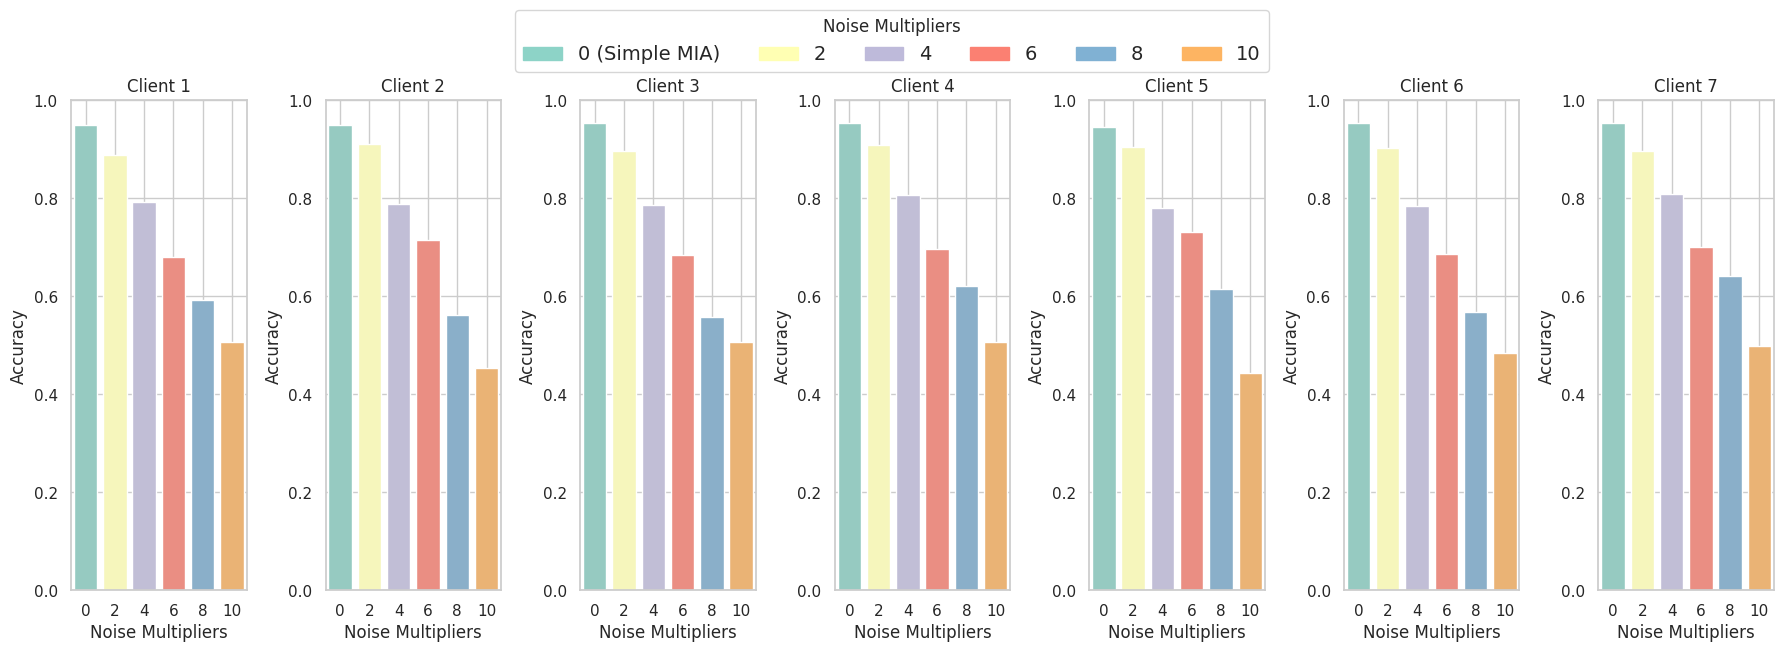


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(client_f1_scores.values()), palette=noise_colors)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(client_f1_scores.values()), palette=noise_colors)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(client_f1_scores.values()), palette=noise_colors)


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=noise_labels, y=list(cli

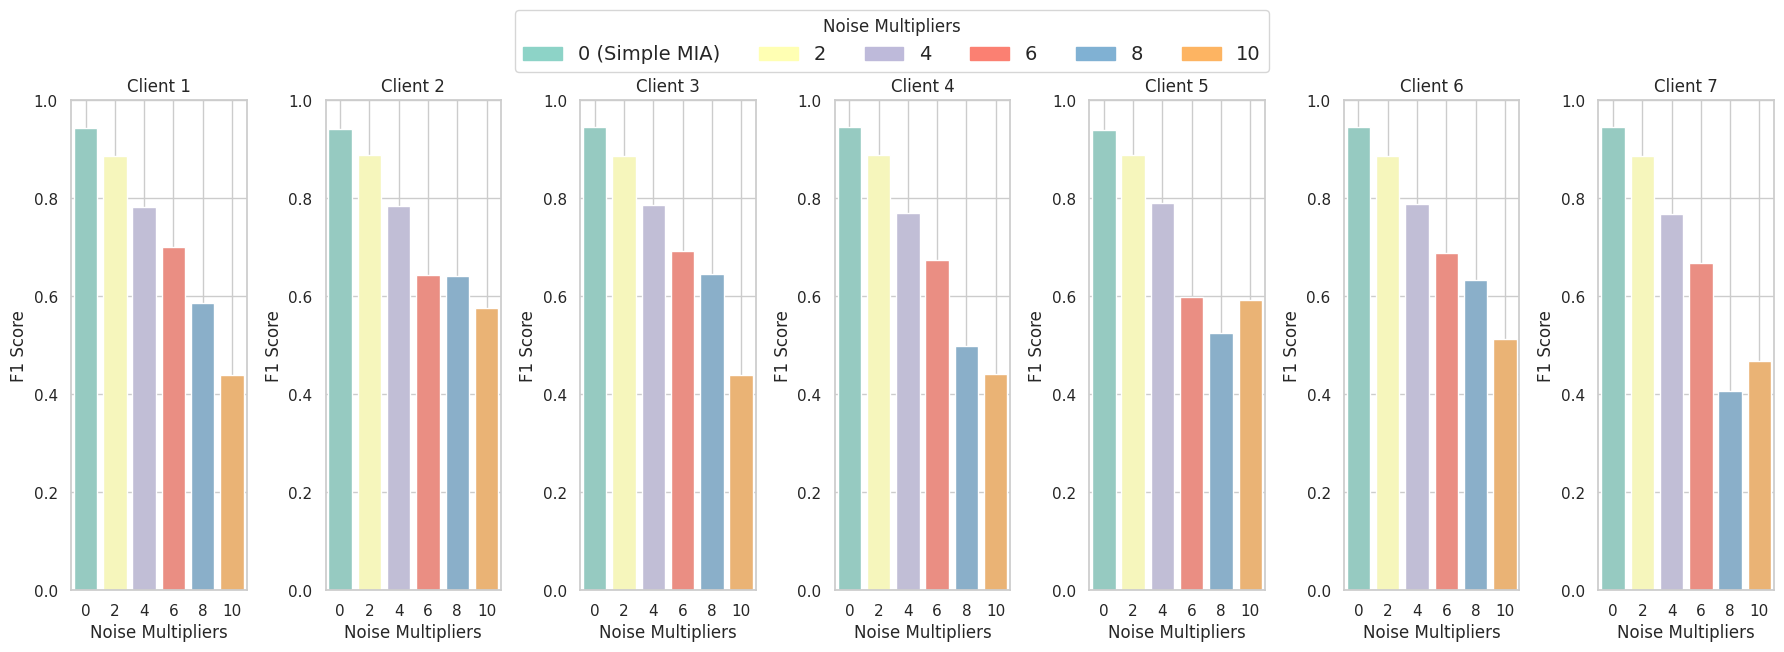

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec


# Number of clients
num_clients = len(final_metrics[0])  # Assuming all noise levels have the same number of clients

# Set seaborn style
sns.set(style="whitegrid")

# Define labels and colors for noise levels
noise_labels = list(final_metrics.keys())
noise_colors = sns.color_palette("Set3", len(noise_labels))

# Create legend handles and labels (separate formatting for label with "color")
legend_handles = [Patch(color=c) for c in noise_colors]
legend_labels = ["0 (Simple MIA)"]  # Special label with "color" for "0" noise level
legend_labels += [label for label in noise_labels[1:]]  # Labels without "color" for others


# Create common figure and grid for subplots
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, num_clients, figure=fig)  # One row, num_clients columns


for i in range(num_clients):
    client_accuracies = {noise_value: final_metrics[noise_value][i]["test_accuracy"] for noise_value in final_metrics.keys()}
    ax = fig.add_subplot(gs[i])  # Add subplot to the grid

    sns.barplot(ax=ax, x=noise_labels, y=list(client_accuracies.values()), palette=noise_colors)
    ax.set_title(f'Client {i + 1}')
    ax.set_xlabel('Noise Multipliers')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1)
    ax.grid(True)


# Calculate legend width and adjust top margin
legend_width = len(noise_labels) * 0.1  # Adjust as needed for desired width
plt.subplots_adjust(top=0.8)  # Reduce top margin slightly

# Add legend outside the loop (once for all plots)
fig.legend(handles, legend_labels, title='Noise Multipliers', loc='upper center',
            ncol=len(noise_labels),  # Force one row
            bbox_to_anchor=(0.5, 1 + legend_width / fig.get_figheight()),
            prop={'size': 14})  # Adjust font size as needed


plt.tight_layout()
# Save Accuracy plot to PDF
with PdfPages('/home/mirwais/Downloads/AttackRates_Accuracy.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')
plt.show()


# Plotting for F1 score (similar structure as accuracy)
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, num_clients, figure=fig)

for i in range(num_clients):
    client_f1_scores = {noise_value: final_metrics[noise_value][i]["test_f1"] for noise_value in final_metrics.keys()}
    ax = fig.add_subplot(gs[i])

    sns.barplot(ax=ax, x=noise_labels, y=list(client_f1_scores.values()), palette=noise_colors)
    ax.set_title(f'Client {i + 1}')
    ax.set_xlabel('Noise Multipliers')
    ax.set_ylabel('F1 Score')
    ax.set_ylim(0, 1)
    ax.grid(True)

# Adjust top margin and add legend outside the loop (once for all plots)
plt.subplots_adjust(top=0.8)  # Reduce top margin slightly
legend_width = len(noise_labels) * 0.1  # Adjust as needed for desired width
fig.legend(handles, legend_labels, title='Noise Multipliers', loc='upper center',
            ncol=len(noise_labels),  # Force one row
            bbox_to_anchor=(0.5, 1 + legend_width / fig.get_figheight()),
            prop={'size': 14})  # Adjust font size as needed

plt.tight_layout()
# Save F1 Score plot to PDF
with PdfPages('/home/mirwais/Downloads/AttackRates_F1Score.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')
plt.show()


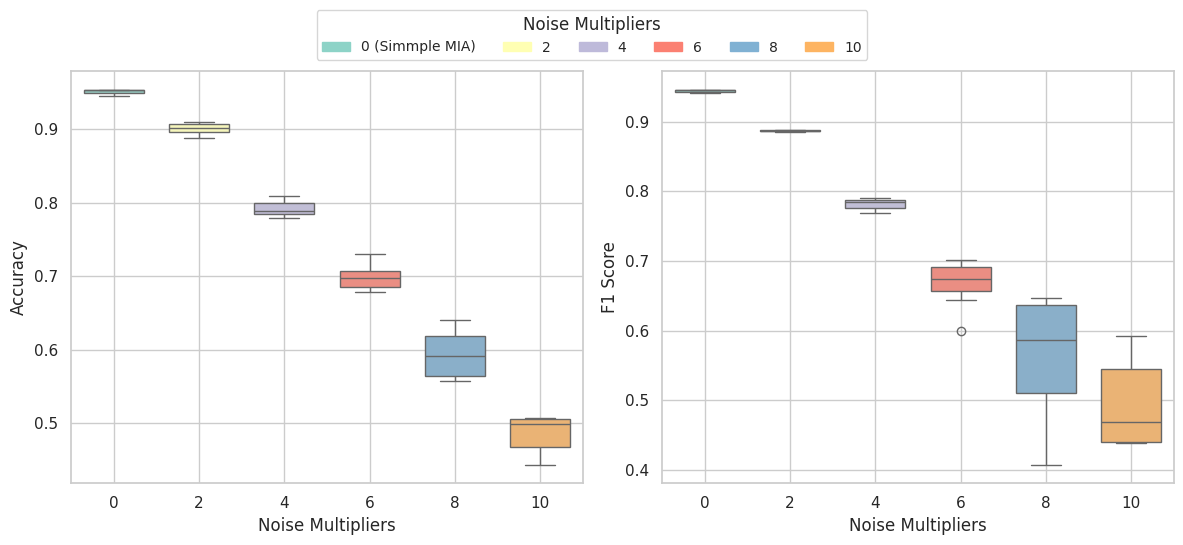

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages


# Extract client-wise metrics for each noise level
client_accuracies = {noise_value: [metrics["test_accuracy"] for metrics in client_metrics] for noise_value, client_metrics in final_metrics.items()}
client_f1_scores = {noise_value: [metrics["test_f1"] for metrics in client_metrics] for noise_value, client_metrics in final_metrics.items()}

# Set seaborn style and define labels/colors
sns.set(style="whitegrid")

noise_labels = list(client_accuracies.keys())
noise_colors = sns.color_palette("Set3", len(noise_labels))

# Create legend handles and labels (separate formatting for label with "color")
handles = [Patch(color=c) for c in noise_colors]
legend_labels = ["0 (Simmple MIA)"]
legend_labels += [label for label in noise_labels[1:]]  # Labels without "color"

# Plotting
fig_f1 = plt.figure(figsize=(12, 5))  # Reduce figure height

# Plot client accuracy for each noise level
plt.subplot(1, 2, 1)
sns.boxplot(data=list(client_accuracies.values()), palette="Set3", width=0.7)
plt.xticks(ticks=range(len(client_accuracies)), labels=list(client_accuracies.keys()))
# plt.title('Client Accuracy Comparison')
plt.xlabel('Noise Multipliers')
plt.ylabel('Accuracy')
plt.grid(True)


# Plot client F1 score for each noise level
plt.subplot(1, 2, 2)
sns.boxplot(data=list(client_f1_scores.values()), palette="Set3", width=0.7)
plt.xticks(ticks=range(len(client_f1_scores)), labels=list(client_f1_scores.keys()))
# plt.title('Client F1 Score Comparison')
plt.xlabel('Noise Multipliers')
plt.ylabel('F1 Score')
plt.grid(True)


# Adjust top margin and add legend outside the loop
plt.subplots_adjust(top=0.8)  # Reduce top margin slightly

fig_f1.legend(handles, legend_labels, title='Noise Multipliers', loc='upper center',
            ncol=len(noise_labels),  # Force one row
            bbox_to_anchor=(0.5, 1.1),
            prop={'size': 10})  # Adjust font size as needed

plt.tight_layout()
# Save F1 Score plot to PDF
with PdfPages('/home/mirwais/Downloads/Simple_Noisy_MIA_Models.pdf') as pdf:
    pdf.savefig(fig_f1, bbox_inches='tight')
plt.show()
